In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import importlib
import sys

sys.path.append('..')

import src.feature_engineering
import src.preprocessing

importlib.reload(src.feature_engineering)
importlib.reload(src.preprocessing)

from src.preprocessing import TextPreprocessor
from src.feature_engineering import extract_features
from src.models.naive_bayes import train_nb
from src.models.logistic_reg import train_lr
from src.models.svm_classifier import train_svm

In [ ]:
# Load and preprocess data
df = pd.read_csv('../data/fake reviews dataset.csv').sample(2000, random_state=42)

# Preprocess text and extract sentiment
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['text_'].apply(preprocessor.clean_text)
df['vader_compound'] = df['text_'].apply(preprocessor.get_vader_score)

# Split data before feature engineering (prevents data leakage)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
y_train = df_train['label']
y_test = df_test['label']

# Extract features (TF-IDF fitted only on training data)
X_train, X_test, _ = extract_features(df_train, df_test=df_test)

if X_train.min() < 0 or X_test.min() < 0:
    print(f"WARNING: Negative values detected before normalization!")
    print(f"X_train min: {X_train.min():.6f}, X_test min: {X_test.min():.6f}")
    print("Applying normalization fix...")
    
    sentiment_col_idx = X_train.shape[1] - 1
    
    X_train[:, sentiment_col_idx] = (X_train[:, sentiment_col_idx] + 1.0) / 2.0
    X_test[:, sentiment_col_idx] = (X_test[:, sentiment_col_idx] + 1.0) / 2.0
    
    print("✓ Normalization applied to sentiment features")

print(f"\nX_train shape: {X_train.shape}")
print(f"X_train min value: {X_train.min():.6f}")
print(f"X_train max value: {X_train.max():.6f}")
print(f"X_test min value: {X_test.min():.6f}")
print(f"X_test max value: {X_test.max():.6f}")

if X_train.min() < 0 or X_test.min() < 0:
    print("ERROR: Still have negative values after normalization!")
else:
    print("✓ All values are non-negative - ready for MultinomialNB")


X_train shape: (1600, 5002)
X_train min value: 0.000000
X_train max value: 1.000000
X_test min value: 0.000000
X_test max value: 1.000000
✓ All values are non-negative - ready for MultinomialNB


NB Baseline Accuracy: 0.8175
LR Baseline Accuracy: 0.8100
      Training on 1,600 samples (full dataset)... ✓
SVM Baseline Accuracy: 0.8275


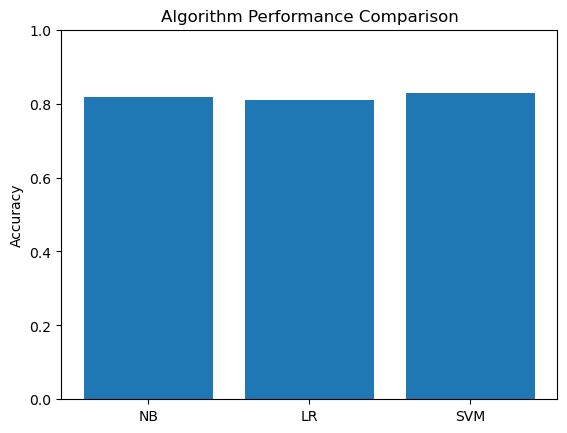

In [3]:
results = {}
for name, train_func in [("NB", train_nb), ("LR", train_lr), ("SVM", train_svm)]:
    try:
        model = train_func(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        results[name] = acc
        print(f"{name} Baseline Accuracy: {acc:.4f}")
    except ValueError as e:
        if "Negative values" in str(e):
            print(f"ERROR: {name} failed due to negative values in features.")
            print("This means the VADER sentiment normalization is not being applied.")
            print("Please restart the kernel and run all cells from the beginning.")
            break
        else:
            raise

# Visualize comparison
if results:
    plt.bar(results.keys(), results.values())
    plt.ylabel('Accuracy')
    plt.title('Algorithm Performance Comparison')
    plt.ylim(0, 1)
    plt.show()
else:
    print("No results to visualize. Please fix the negative values issue first.")